# Adversarial Attacks with ResNet-34 (Updated)

This notebook performs two tasks on a 100-class subset of ImageNet-1K:
1. Evaluate clean top-1/top-5 accuracy using a pretrained ResNet-34.
2. Generate adversarial examples using FGSM (ε=0.02), re-evaluate accuracy, and visualize misclassifications with human-readable labels.


## 1. Imports and Preprocessing

In [1]:
import json
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalization constants
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms),
])

## 2. Task 1: Clean Accuracy Evaluation

In [ ]:
# Load dataset
dataset = datasets.ImageFolder(
    root="TestDataSet",
    transform=plain_transforms
)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8)

# Load mapping for 401–500 indices
with open("TestDataSet/labels_list.json") as f:
    entries = json.load(f)
idx_to_true = {i: int(entries[i].split(":",1)[0]) for i in range(len(entries))}

# Load pretrained ResNet-34
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval().to(device)

# Evaluate clean accuracy
top1 = top5 = total = 0
with torch.no_grad():
    for imgs, labels in tqdm(loader, desc="Clean Eval"):
        imgs = imgs.to(device)
        logits = model(imgs)
        _, p5 = logits.topk(5, dim=1)
        true = torch.tensor([idx_to_true[int(l)] for l in labels], device=p5.device)
        top1 += (p5[:,0] == true).sum().item()
        top5 += (p5 == true.unsqueeze(1)).any(dim=1).sum().item()
        total += labels.size(0)

print(f"Clean Top-1 accuracy: {top1/total*100:.2f}%")
print(f"Clean Top-5 accuracy: {top5/total*100:.2f}%")

Clean Eval: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]

Clean Top-1 accuracy: 76.00%
Clean Top-5 accuracy: 94.20%


## 3. Task 2: FGSM Attack & Adversarial Evaluation

In [3]:
# FGSM helper functions and bounds
cn = torch.tensor(mean_norms, device=device)[:,None,None]
cs = torch.tensor(std_norms, device=device)[:,None,None]
min_val = (0 - cn) / cs
max_val = (1 - cn) / cs

def fgsm(image, eps, grad):
    return torch.max(torch.min(image + eps * grad.sign(), max_val), min_val)

# Prepare for FGSM loop
si_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

epsilon = 0.02
# epsilon = 0.02/std_norms
orig_images = []
adv_images = []
adv_labels = []
orig_preds = []
adv_preds = []

# Run FGSM on every image
for img, lab in tqdm(si_loader, desc="FGSM Attack"):
    img = img.to(device).detach().requires_grad_(True)
    lab = lab.to(device)

    # store clean image
    orig_images.append(img.squeeze(0).cpu())

    # forward + loss
    out = model(img)
    true_idx = torch.tensor([idx_to_true[int(lab)]], device=device)
    loss = F.cross_entropy(out, true_idx)

    # backward
    model.zero_grad()
    loss.backward()
    grad = img.grad.data

    # generate adversarial
    adv = fgsm(img, epsilon, grad).detach().to(torch.float32)

    adv_images.append(adv.squeeze(0).cpu())
    adv_labels.append(int(lab))
    orig_preds.append(out.argmax(1).item())
    adv_preds.append(model(adv).argmax(1).item())

# Build adversarial dataset
adv_tensor = torch.stack(adv_images)
lab_tensor = torch.tensor(adv_labels)
adv_set = TensorDataset(adv_tensor, lab_tensor)
adv_loader = DataLoader(adv_set, batch_size=32, shuffle=False)


FGSM Attack: 100%|██████████| 500/500 [00:03<00:00, 156.80it/s]


In [4]:
# Evaluate adversarial accuracy
top1 = top5 = total = 0
with torch.no_grad():
    for imgs, labs in adv_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        _, p5 = out.topk(5, dim=1)
        true = torch.tensor([idx_to_true[int(l)] for l in labs], device=p5.device)
        top1 += (p5[:,0] == true).sum().item()
        top5 += (p5 == true.unsqueeze(1)).any(dim=1).sum().item()
        total += labs.size(0)

print(f"Adversarial Top-1 accuracy: {top1/total*100:.2f}%")
print(f"Adversarial Top-5 accuracy: {top5/total*100:.2f}%")

Adversarial Top-1 accuracy: 6.20%
Adversarial Top-5 accuracy: 35.40%


## 4. Visualization of Misclassifications

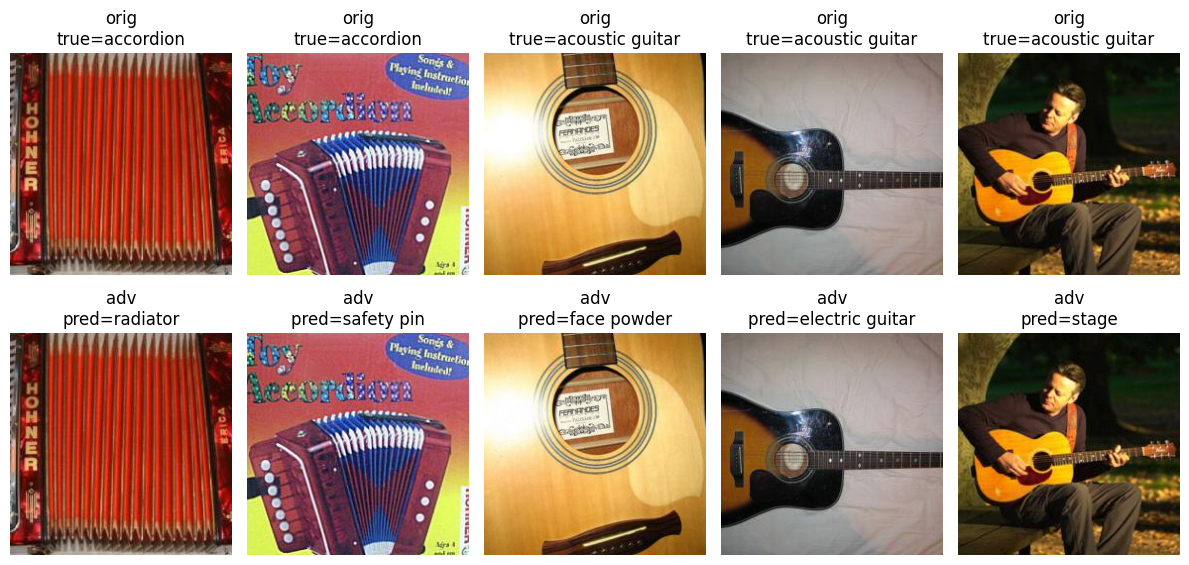

In [6]:
# Prepare label maps for human-readable names
weights = models.ResNet34_Weights.IMAGENET1K_V1
all_labels = weights.meta['categories']
label_401_to_500 = {i: all_labels[i] for i in range(401, 501)}

# Find 3 examples where clean was correct but adv is misclassified
picked = []
for i, (o, a, l) in enumerate(zip(orig_preds, adv_preds, adv_labels)):
    true_img_idx = idx_to_true[l]
    if o == true_img_idx and a != true_img_idx:
        picked.append(i)
    if len(picked) >= 5:
        break

# Un-normalizer
inv_norm = transforms.Normalize(
    mean=(-mean_norms / std_norms).tolist(),
    std=(1 / std_norms).tolist()
)

# Plot
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for col, i in enumerate(picked):
    true_idx = idx_to_true[adv_labels[i]]
    adv_idx = adv_preds[i]

    true_name = label_401_to_500[true_idx]
    adv_name = all_labels[adv_idx]

    for row, img in enumerate([orig_images[i], adv_images[i]]):
        ax = axes[row, col]
        # im = inv_norm(img).permute(1, 2, 0).clamp(0, 1).numpy()
        im = inv_norm(img).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
        ax.imshow(im)
        ax.axis('off')
        if row == 0:
            ax.set_title(f"orig\ntrue={true_name}")
        else:
            ax.set_title(f"adv\npred={adv_name}")
plt.tight_layout()
plt.show()

Evaluating clean samples...
Clean   Top‑1 0.00%   Top‑5 0.00%

--- PGD attack with 5 steps ---
PGD-5   Top‑1 0.00%   Top‑5 0.00%


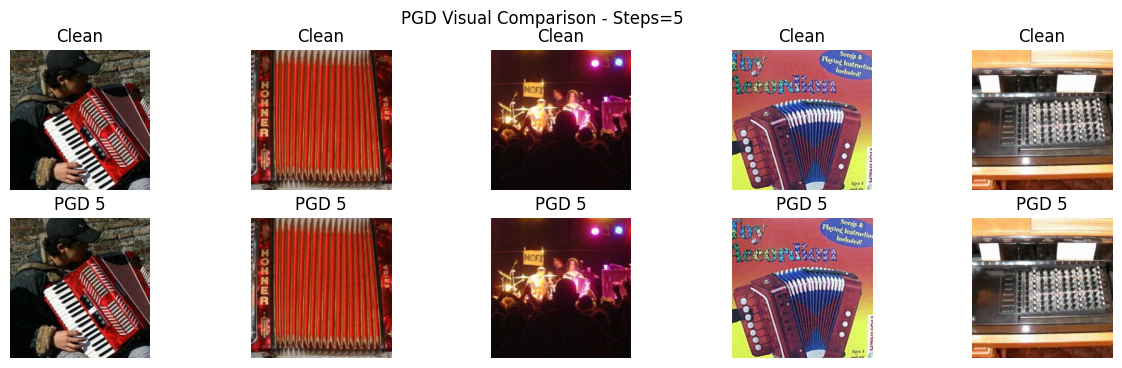


--- PGD attack with 10 steps ---
PGD-10  Top‑1 0.00%   Top‑5 0.00%


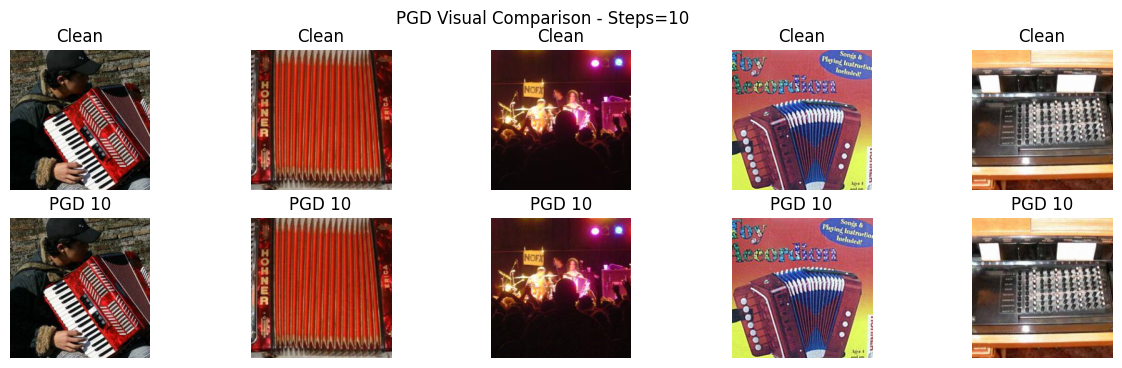


--- PGD attack with 15 steps ---
PGD-15  Top‑1 0.00%   Top‑5 0.00%


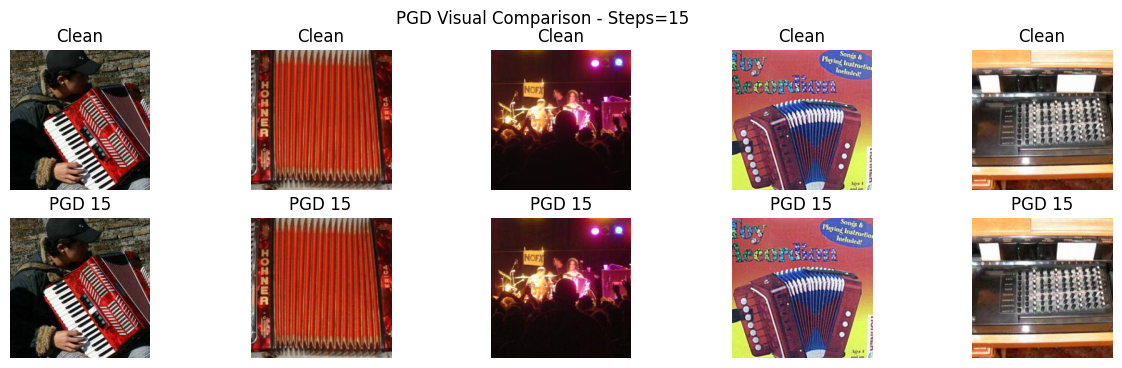

In [2]:
# PGD Attack Comparison: Step=5,10,15 with Visualization

import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0); np.random.seed(0)

# Normalization
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
normalize = transforms.Normalize(mean.tolist(), std.tolist())

std_tensor = torch.tensor(std, device=device).view(3,1,1)
min_val = torch.tensor(((0 - mean) / std).reshape(3,1,1), device=device)
max_val = torch.tensor(((1 - mean) / std).reshape(3,1,1), device=device)

# Load dataset
transform = transforms.Compose([transforms.ToTensor(), normalize])
dataset = datasets.ImageFolder(root="TestDataSet", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

# Load model
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)
model.eval()

@torch.no_grad()
def evaluate(model, loader, device, tag=""):
    top1 = top5 = tot = 0
    for x, labs in loader:
        x = x.to(device)
        labs = labs.to(device)
        logits = model(x)
        top1 += (logits.argmax(1) == labs).sum().item()
        top5 += (logits.topk(5, 1)[1] == labs[:, None]).any(1).sum().item()
        tot += labs.size(0)
    acc1, acc5 = top1 / tot, top5 / tot
    print(f"{tag:<8}Top‑1 {acc1*100:.2f}%   Top‑5 {acc5*100:.2f}%")
    return acc1, acc5

def pgd_attack(model, x, y, eps_n, alpha_n, steps, min_v, max_v, rand_start=True):
    if rand_start:
        x_adv = x + torch.empty_like(x).uniform_(-1, 1) * eps_n
        x_adv = torch.clamp(x_adv, min_v, max_v)
    else:
        x_adv = x.clone()
    for _ in range(steps):
        x_adv = x_adv.detach().requires_grad_(True)
        model.zero_grad(set_to_none=True)
        F.cross_entropy(model(x_adv), y).backward()
        x_adv = x_adv + alpha_n * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, x - eps_n, x + eps_n)
        x_adv = torch.clamp(x_adv, min_v, max_v)
    return x_adv.detach()

# Clean accuracy evaluation
print("Evaluating clean samples...")
sample_imgs, sample_labs = next(iter(loader))
sample_imgs = sample_imgs[:5].to(device)
sample_labs = sample_labs[:5].to(device)

eps = 0.02
eps_n = torch.tensor(eps / std, device=device).view(3,1,1)

_ = evaluate(model, DataLoader(TensorDataset(sample_imgs, sample_labs)), device, "Clean")

# PGD with multiple steps
for steps in [5, 10, 15]:
    alpha = eps / steps
    alpha_n = torch.tensor(alpha / std, device=device).view(3,1,1)
    print(f"\n--- PGD attack with {steps} steps ---")
    adv_list, lab_list = [], []
    for x, labs in loader:
        x = x.to(device)
        y = labs.to(device)
        adv = pgd_attack(model, x, y, eps_n, alpha_n, steps, min_val, max_val)
        adv_list.append(adv)
        lab_list.append(labs)
        if len(adv_list) * 8 >= 100: break  # speed limit
    adv_all = torch.cat(adv_list)
    lab_all = torch.cat(lab_list)
    adv_loader = DataLoader(TensorDataset(adv_all, lab_all), batch_size=8)
    evaluate(model, adv_loader, device, f"PGD-{steps}")

    # Visualize attack results
    adv_vis = pgd_attack(model, sample_imgs, sample_labs, eps_n, alpha_n, steps, min_val, max_val)
    fig, axs = plt.subplots(2, 5, figsize=(15, 4))
    for i in range(5):
        axs[0, i].imshow((sample_imgs[i].cpu() * std_tensor.cpu() + torch.tensor(mean).view(3,1,1)).permute(1,2,0).clamp(0,1))
        axs[0, i].axis("off")
        axs[0, i].set_title("Clean")
        axs[1, i].imshow((adv_vis[i].cpu() * std_tensor.cpu() + torch.tensor(mean).view(3,1,1)).permute(1,2,0).clamp(0,1))
        axs[1, i].axis("off")
        axs[1, i].set_title(f"PGD {steps}")
    plt.suptitle(f"PGD Visual Comparison - Steps={steps}")
    plt.show()
